In [2]:

import subprocess
import sys
sys.path.insert(0,'..')
from pathlib import Path
import os
import random

import torch
import torch.nn as nn
from torch.nn.functional import one_hot
from torch import Tensor
from typing import Union

import matplotlib.pylab as plt

import time
import numpy as np
import torch as th
import torch.nn as nn
from torch.utils import data
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, WeightedRandomSampler
import torch.optim.lr_scheduler as lr_scheduler

from focal_loss import FocalLoss
from utils import _axat, _atxa, _mvmt
import seaborn as sns


def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package],
                         stdout=subprocess.DEVNULL,
                         stderr=subprocess.DEVNULL
                         )
required_packages = [
    "geoopt",
    "pyriemann",
]
for package in required_packages:
    try:
        __import__(package)
        print(f"{package} is already installed.")
    except ImportError:
        print(f"{package} is not installed. Installing...")
        install(package)

import geoopt
from pyriemann.utils.covariance import covariances, normalize


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.manifold import TSNE
import pandas as pd


use_cuda = th.cuda.is_available()
device = th.device("cuda:0" if use_cuda else "cpu")
print(device)

geoopt is not installed. Installing...
pyriemann is not installed. Installing...
cpu


## Defining Flags and Variables

In [3]:

# Flags and Parameters
root_dir = r"/kaggle/input/bzh-data-frh-01-02-03"
npz_file = "bzh_interpolated_data_fr_01_98_p_norm_data.npz"
# npz_file1 = "bzh_interpolated_data_fr_01_98_p_norm_data.npz"
# npz_file2 = "bzh_interpolated_data_fr_02_98_p_norm_data.npz"
# npz_file3 = "bzh_interpolated_data_fr_03_98_p_norm_data.npz"
folder_name = "bzh_combo_frh01"
test_index = 2
os.makedirs(folder_name, exist_ok=True)
combine = False
batch_size = 64  # batch size
n_classes = 7
random_seed = 42
test_size = 0.2
val_size = 0.5
temp = False  # Whether the data is in temporal mode
val = False # Whether to create a validation loader
combo = True  # Whether the data is in combo mode
checkpoint_path = "/kaggle/working/bzh_combo_frh01/best_model.pth"
model_name = "bzh_combo_frh01"
figure_name = "CM_bzh_combo_frh01"
tsne_fig_name ="Tsne_bzh_combo_frh01"
plot_figure_name = "training_validation_results_bzh_combo_frh01"

# for model
lr=1e-2
epochs=200
gamma_value=0.95
loss = "focal"
gamma_loss = 3
step_size=30
step_lr = False
linear_classif = False


## Model, Dataset, and Classifier definition

In [4]:
class BusemanSimilarityClassifier(nn.Module):
    def busemann_spd(self, logM):
        """
        Compute the Busemann similarity for Symmetric Positive Definite (SPD) matrices.
        
        :param logM: Logarithm of SPD matrices, shape (b, n, n)
        :return: Similarity scores, shape (b, n_proto)
        """
        return logM.reshape(logM.shape[0], -1) @ self.proto.reshape(self.proto.shape[0], -1).T
    def __init__(self,dim1,n_proto,n_classes,optim_proto=True):
        super().__init__()
        self.n_proto = n_proto
        self.n_classes = n_classes
        self.dim1 = dim1
        
        self.manifold = geoopt.Stiefel()

        # Random projection directions, shape (d-1, num_projections)
        theta = np.random.normal(size=(self.n_proto, self.dim1))
        theta = th.nn.functional.normalize(th.from_numpy(theta), p=2, dim=-1).type(th.float64).to(device)
        #self.D = theta[:,None] * th.eye(theta.shape[-1],dtype=th.float64, device=device)
        self.register_parameter("theta_proto", geoopt.ManifoldParameter(theta, geoopt.Sphere()))
        #self.theta_proto=theta

        ## Random orthogonal matrices
        Z = th.randn((self.n_proto, self.dim1, self.dim1), dtype=th.float64, device=device)
        self.Q = th.svd(Z)[0]
        self.manifold.assert_check_point_on_manifold(self.Q)
        self.register_parameter("Q_proto", geoopt.ManifoldParameter(self.Q, self.manifold))
        self.proto = _mvmt(self.Q_proto, self.theta_proto, self.Q_proto)
        # linear layer
        self.linear = nn.Linear(self.n_proto, self.n_classes).double()

    def forward(self, x):
        self.proto = _mvmt(self.Q_proto, self.theta_proto, self.Q_proto)
        y = self.linear(self.busemann_spd(x))#.view(sim_embedding.shape[0], -1))
        return y
    
    def embed(self, x):
        self.proto = _mvmt(self.Q_proto, self.theta_proto, self.Q_proto)
        return self.busemann_spd(x)

In [5]:
def regularize_matrix(matrix, epsilon=1e-10):
    """
    Adds a small value to the diagonal elements of the matrix to regularize it.
    """
    identity = th.eye(matrix.size(-1), device=matrix.device, dtype=matrix.dtype) * epsilon
    return matrix + identity

#apply regularized shrinkage to the matrix
def regularized_shrinkage(matrix, shrinkage=0.5, epsilon=1e-10):
    """
    Apply regularized shrinkage to the matrix.
    """
    identity = th.eye(matrix.size(-1), device=matrix.device, dtype=matrix.dtype) * epsilon
    return shrinkage * matrix + (1 - shrinkage) * identity

class LogEucRResNet(nn.Module):
    def __init__(self, inputdim=10, dim1=8, n_proto=8, classes=7, embed_only=False, linear_classif=False):
        super().__init__()
        self.inputdim = inputdim
        self.dim1 = dim1
        self.n_proto = n_proto
        self.classes = classes
        self.embed_only = embed_only
        self.linear_classif = linear_classif

        self.manifold_Stiefel = geoopt.Stiefel()
        self.manifold_SPD = geoopt.SymmetricPositiveDefinite("LEM")
        
        # init first bimap
        bm1 = th.randn((1, self.inputdim, self.dim1), dtype=th.float64)
        bm1 = th.svd(bm1)[0]
        self.register_parameter("bimap1", geoopt.ManifoldParameter(bm1, self.manifold_Stiefel))
        
        P = th.randn((1, self.dim1, self.dim1), dtype=th.float64)
        P = th.svd(P)[0]

        self.register_parameter("P1", geoopt.ManifoldParameter(P, self.manifold_Stiefel))

        self.classiflayer=BusemanSimilarityClassifier(self.dim1,self.n_proto, classes)
        self.fc_layer = nn.Linear(self.dim1 * self.dim1, self.classes).double()
        self.softmax =  nn.Softmax(dim=-1)

        self.spectrum_map = nn.Sequential(
            nn.Conv1d(1, 10, 5, padding="same").double(),
            nn.LeakyReLU(),
            nn.BatchNorm1d(10).double(),
            nn.Conv1d(10, 5, 3, padding="same").double(),
            nn.LeakyReLU(),
            nn.BatchNorm1d(5).double(),
            nn.Conv1d(5, 1, 3, padding="same").double(),
        )
        
    def forward(self, x):
        x = _atxa(self.bimap1, x)
        # print("I am x", x)
        # x = regularize_matrix(x)
        x = regularized_shrinkage(x)
        # print("I am x after", x)
        evecs, eigs, _ = th.svd(x)
        f_eigs = self.spectrum_map(eigs) # spectral map
        v1 = _mvmt(self.P1, f_eigs, self.P1)            
        v1 = self.manifold_SPD.proju(x, v1)
        eigs = th.clamp(eigs, 1e-8, 1e8)
        log_x = _mvmt(evecs, th.log(eigs), evecs)     
        x = log_x + v1
        if self.embed_only:
            return x.reshape(x.shape[0],-1)
        elif self.linear_classif:
            return self.softmax(self.fc_layer(x.reshape(x.shape[0],-1)))
        else:
            return self.softmax(self.classiflayer(x)) # Buseman Similarity Classifier when single modality is used
    def partial_forward(self, x):
        x = _atxa(self.bimap1, x)
        evecs, eigs, _ = th.svd(x)
        f_eigs = self.spectrum_map(eigs)
        v1 = _mvmt(self.P1, f_eigs, self.P1)
        v1 = self.manifold_SPD.proju(x, v1)
        eigs = th.clamp(eigs, 1e-8, 1e8)
        log_x = _mvmt(evecs, th.log(eigs), evecs)
        x = log_x + v1
        return self.classiflayer.embed(x)
            
class LogEucRResNet_Combo(nn.Module):
    def __init__(self, inputdim_temp=71, dim1_temp=57, inputdim_spec=10, dim1_spec=8, n_proto=8, classes=7, buseman_classif=True):
        super().__init__()
        self.classes = classes
        self.buseman_classif = buseman_classif
        self.model_temp = LogEucRResNet(inputdim_temp, dim1_temp, n_proto, embed_only=True)
        self.model_spectral = LogEucRResNet(inputdim_spec, dim1_spec, n_proto, embed_only=True)
        
        self.classiflayer_temp = BusemanSimilarityClassifier(dim1_temp, n_proto, classes)
        self.classiflayer_spec = BusemanSimilarityClassifier(dim1_spec, n_proto, classes)
        
        if linear_classif:
            self.fc_layer = nn.Linear(dim1_spec*dim1_spec+dim1_temp*dim1_temp, classes).double()
        else:
            self.fc_layer = nn.Linear(classes*2, classes).double()        
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x1, x2):
        out_1 = self.model_temp(x1)
        out_2 = self.model_spectral(x2)
        
        if self.buseman_classif:
            out_temp = self.classiflayer_temp(out_1)
            # print(out_temp.shape)
            out_spec = self.classiflayer_spec(out_2)
            # print(out_spec.shape)
            x = th.cat((out_temp, out_spec), dim=1)
            # print(x.shape)
        else:
            x = th.concat((out_1, out_2), dim=1)
            # print(x.shape)
            
        return self.softmax(self.fc_layer(x))

    def partial_forward(self, x1, x2):
        out_1 = self.model_temp.partial_forward(x1)
        out_2 = self.model_spectral.partial_forward(x2)
        x = th.concat((out_1, out_2), dim=1)
        return self.classiflayer.embed(x)

In [6]:
class TS_COV(Dataset):
    def __init__(self, root_dir, np_file, estimator='scm', combo=True, temp=False):
        self.root_dir = root_dir
        self.np_file = np_file
        self.estimator = estimator
        self.assume_centered = True
        self.combo = combo
        self.temp = temp
        self.x, self.y, self.class_names = self.load_data()
        #self.cov = normalize(self.calculate_covariances(),'corr')
        self.x1 = self.calculate_covariances_36()
        self.x2 = self.calculate_covariances_10()
    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x1, x2= self.x1[idx], self.x2[idx]
        y_sample = self.y[idx]
        class_name = self.class_names[y_sample]
        x1 = th.from_numpy(np.asarray([x1])).double()
        x2 = th.from_numpy(np.asarray([x2])).double()
        x1,x2 = x1.reshape(1, 71, 71), x2.reshape(1, 10, 10)
        y = th.from_numpy(np.array(y_sample)).long()
        if self.combo:
            return x1,x2, y
        elif self.temp:
            return x1, y
        else:
            return x2, y

    def load_data(self):
        file_path = os.path.join(self.root_dir, self.np_file)
        data = np.load(file_path, allow_pickle= True)
        x = data['series']
        y = data['labels']
        class_names = data['class_names']
        return x, y, class_names

    def calculate_covariances_10(self):
        x_transposed = np.transpose(self.x, (0, 2, 1))
        cov = covariances(x_transposed, estimator=self.estimator, assume_centered=self.assume_centered)
        return cov
    def calculate_covariances_36(self):
        cov = covariances(self.x, estimator=self.estimator, assume_centered=self.assume_centered)
        return cov

## Helper functions

In [7]:
import torch.utils


def initialize_model(combo=True, linear_classif=True, temp=False, device=device):
    if combo:
        if linear_classif:
            model = LogEucRResNet_Combo(buseman_classif=False).to(device)
            print("Combo model with linear classifier")
        else:
            model = LogEucRResNet_Combo(buseman_classif=True).to(device)
            print("Combo model with Buseman classifier")
    elif temp:
        if linear_classif:
            inputdim = 71
            dim1 = 57
            model = LogEucRResNet(inputdim, dim1, linear_classif=True).to(device)
            print("Single modality - Temp model with linear classifier")
        else:
            inputdim = 71
            dim1 = 57
            model = LogEucRResNet(inputdim, dim1, linear_classif=False).to(device)
            print("Single modality - Temp model with Buseman classifier")
    else:
        if linear_classif:
            inputdim = 10
            dim1 = 8
            model = LogEucRResNet(inputdim, dim1, linear_classif=True).to(device)
            print("Single modality - Spectral model with linear classifier")
        else:
            inputdim = 10
            dim1 = 8
            model = LogEucRResNet(inputdim, dim1, linear_classif=False).to(device)
            print("Single modality - Spectral model with Buseman classifier")

    # Get number of trainable parameters
    model.eval()
    trainable_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Trainable total parameters: {trainable_total_params}')
    return model

# calculate the weights for the classes
def calculate_class_weights(labels):
    class_sample_count = np.array([len(np.where(labels == t)[0]) for t in np.unique(labels)])
    weight = 1 - class_sample_count / len(labels)
    return th.from_numpy(weight).double()
# data loaders
def create_data_loaders(dataset, train_indices, val_indices, test_indices, batch_size, val=True):
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_indices))
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(test_indices), shuffle=False)
    
    if val:
        val_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(val_indices))
        return train_loader, val_loader, test_loader
    else:
        return train_loader, test_loader
def create_dataloaders(test_index, dataset1, dataset2, dataset3, dataset4, batch_size=32):
    # Create a list of datasets
    datasets = [dataset1, dataset2, dataset3, dataset4]
    
    # Extract the test dataset using the test_index
    test_dataset = datasets.pop(test_index)
    
    # Save labels for all datasets
    all_labels = []
    for dataset in datasets:
        all_labels.append(dataset.y)  # Assuming y is the attribute that holds labels in each dataset

    # Combine the remaining datasets for training
    train_dataset = torch.utils.data.ConcatDataset(datasets)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, all_labels

# plotting data distribution
def plot_class_distribution(train_loader, val_loader, test_loader, n_classes, combo=False, folder_name=folder_name):
    class_names = test_loader.dataset.class_names
    
    def count_labels(loader, n_classes):
        counts = np.zeros(n_classes)
        for batch in loader:
            if combo:
                _, _, labels = batch  # x1, x2, labels
            else:
                _, labels = batch  # x, labels
            for l in labels:
                counts[l] += 1
        return counts

    train_counts = count_labels(train_loader, n_classes)
    
    if val_loader is not None:
        val_counts = count_labels(val_loader, n_classes)
    else:
        val_counts = np.zeros(n_classes)
    
    test_counts = count_labels(test_loader, n_classes)

    # Bar plot
    plt.figure(figsize=(12, 6))
    plt.bar(np.arange(n_classes) - test_size, train_counts, 0.2, label='Train')
    if val_loader is not None:
        plt.bar(np.arange(n_classes), val_counts, 0.2, label='Validation')
    plt.bar(np.arange(n_classes) + 0.2, test_counts, 0.2, label='Test')
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.yscale('log')
    if val_loader is not None:
        plt.title('Class Distribution in Train, Validation, and Test Sets')
    else:
        plt.title('Class Distribution in Train and Test Sets')
    plt.xticks(np.arange(n_classes), class_names, rotation=45)
    plt.legend(loc='best')
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.bar(np.arange(n_classes), train_counts, alpha=0.5, label='Train')
    plt.bar(np.arange(n_classes), val_counts, alpha=0.5, label='Validation')
    plt.bar(np.arange(n_classes), test_counts, alpha=0.5, label='Test')
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.yscale('log')
    if val_loader is not None:
        plt.title('Histogram of Class Distribution in Train, Validation, and Test Sets')
    else:
        plt.title('Histogram of Class Distribution in Train and Test Sets')
    plt.xticks(np.arange(n_classes), class_names, rotation=45)
    plt.legend(loc='best')
    plt.show()

    # Create a table with the counts
    data = {
        'Class': class_names,
        'Train': train_counts,
        'Validation': val_counts,
        'Test': test_counts
    }
    df = pd.DataFrame(data)
    
    # Print the table
    print("\nClass Distribution Table:")
    print(df)

    # Display the table
    fig, ax = plt.subplots(figsize=(12, 6))  # set size frame
    ax.axis('tight')
    ax.axis('off')
    the_table = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')
    plot_name = os.path.join(folder_name, 'class_distribution_table.png')
    plt.savefig(f'{plot_name}', bbox_inches='tight', dpi=500, pad_inches=0.5)
    plt.show()


In [8]:
def load_checkpoint(model, optimizer, scheduler, checkpoint_path):
    """
    Loads a checkpoint and resumes training from where it left off.

    Parameters:
    - model: The model to load the state dict into.
    - optimizer: The optimizer to load the state dict into.
    - scheduler: The learning rate scheduler to load the state dict into.
    - checkpoint_path: Path to the checkpoint file.

    Returns:
    - start_epoch: The epoch to resume training from.
    - best_loss: The best loss achieved before checkpointing.
    """
    if not checkpoint_path or not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint file not found at '{checkpoint_path}'")

    checkpoint = th.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])

    optimizer_state_dict = checkpoint['optimizer_state_dict']
    # Ensure 'step' key exists in the optimizer state
    for state in optimizer_state_dict['state'].values():
        if 'step' not in state:
            state['step'] = 0  # Initialize 'step' if missing

    optimizer.load_state_dict(optimizer_state_dict)
    
    if scheduler is not None and 'scheduler_state_dict' in checkpoint:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch']
    best_loss = checkpoint.get('loss', float('inf'))

    return start_epoch, best_loss, checkpoint

def train_one_epoch(model, train_loader, loss_fn, optimizer, device, combo=False):
    model.train()
    loss_train, acc_train = [], []
    
    for batch in train_loader:
        if combo:
            x1, x2, y = batch
            x1 = x1.to(device)
            x2 = x2.to(device)
            inputs = (x1, x2)
        else:
            x, y = batch
            x = x.to(device)
            inputs = (x,)
        y = y.to(device).long()
        optimizer.zero_grad()
        
        # Forward pass
        out = model(*inputs)
        l = loss_fn(out, y)
        
        acc, loss = (out.argmax(1) == y).cpu().numpy().sum() / out.shape[0], l.cpu().data.numpy()
        loss_train.append(loss)
        acc_train.append(acc)
        l.backward()
        optimizer.step()

    acc_train = np.asarray(acc_train).mean()
    loss_train = np.asarray(loss_train).mean()
    
    return loss_train, acc_train

def validate_one_epoch(model, val_loader, loss_fn, device, combo=False):
    model.eval()
    loss_val, acc_val_list = [], []
    y_true, y_pred = [], []

    for batch in val_loader:
        if combo:
            x1, x2, y = batch
            x1 = x1.to(device)
            x2 = x2.to(device)
            inputs = (x1, x2)
        else:
            x, y = batch
            x = x.to(device)
            inputs = (x,)
        y = y.to(device).long()
        
        with th.no_grad():
            # Forward pass
            out = model(*inputs)
            l = loss_fn(out, y)
        
        loss_val.append(l.cpu().data.numpy())
        predicted_labels = out.argmax(1)
        y_true.extend(list(y.cpu().numpy()))
        y_pred.extend(list(predicted_labels.cpu().numpy()))
        acc = (predicted_labels == y).cpu().numpy().sum() / out.shape[0]
        acc_val_list.append(acc)
    
    acc_val = np.asarray(acc_val_list).mean()
    loss_val = np.asarray(loss_val).mean()
    f1_test = f1_score(y_true, y_pred, average='macro')
    
    return loss_val, acc_val, f1_test, y_true, y_pred

def train_model(model, train_loader, val_loader, loss_fn, optimizer, scheduler, epochs, folder_name, checkpoint_path=None, combo=False):
    t1, t2, t3, t4, t5 = [], [], [], [], []
    device = th.device("cuda" if th.cuda.is_available() else "cpu")

    min_val_loss = float('inf')
    best_epoch = 0
    start_epoch = 0

    # Load checkpoint if exists
    if checkpoint_path and os.path.exists(checkpoint_path):
        start_epoch, min_val_loss, checkpoint = load_checkpoint(model, optimizer, scheduler, checkpoint_path)
        t1 = checkpoint['train_loss_history']
        t2 = checkpoint['train_accuracy_history']
        t3 = checkpoint['val_loss_history']
        t4 = checkpoint['val_accuracy_history']
        best_epoch = checkpoint['epoch']
        print(f'Resuming training from epoch {start_epoch} with best loss {min_val_loss}')

    for epoch in range(start_epoch, epochs):
        start_time = time.time()  # Start time of the epoch

        # Training phase
        loss_train, acc_train = train_one_epoch(model, train_loader, loss_fn, optimizer, device, combo)
        scheduler.step()

        t1.append(loss_train)
        t2.append(100 * acc_train)

        # Validation phase
        loss_val, acc_val, f1_test, y_true, y_pred = validate_one_epoch(model, val_loader, loss_fn, device, combo)

        t3.append(loss_val)
        t4.append(100 * acc_val)
        t5.append(100 * f1_test)
        
        print('Epoch {}/{} - Train loss: {:.4f} - Val loss: {:.4f} - Train acc: {:.2f}% - Val acc: {:.2f}% - Test F1-score: {:.2f}'.format(
            epoch + 1, epochs, loss_train, loss_val, 100 * acc_train, 100 * acc_val, 100 * f1_test))

        elapsed_time = time.time() - start_time
        print('Elapsed time: {:.2f} seconds'.format(elapsed_time))
        
        # Save the best model
        if loss_val < min_val_loss:
            min_val_loss = loss_val
            best_epoch = epoch + 1

            ckpt = {
                'epoch': best_epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler is not None else None,
                'train_loss_history': t1,
                'train_accuracy_history': t2,
                'val_loss_history': t3,
                'val_accuracy_history': t4,
                'y_true': y_true,
                'y_pred': y_pred,
                'loss': min_val_loss
            }
            
            best_model_path = os.path.join(folder_name, 'best_model.pth')
            th.save(ckpt, best_model_path)
            print(f'Best model checkpoint saved at {best_model_path}')

    # Save training results to a CSV file
    results_df = pd.DataFrame({
        'epoch': np.arange(1, epochs + 1),
        'train_loss': t1,
        'train_acc': t2,
        'val_loss': t3,
        'val_acc': t4,
        'f1_score': t5
    })
    results_df.to_csv(os.path.join(folder_name, 'training_results.csv'), index=False)

    return t1, t2, t3, t4, t5, best_epoch, best_model_path


In [9]:

def plot_training_results(t1, t2, t3, t4, t5, folder_name, figure_name, best_epoch):
    print(f'Best epoch: {best_epoch}')
    plt.figure(figsize=(12, 8))
    plt.title("Training and Validation Loss and Accuracy")

    # Plot training and validation loss
    p1, = plt.plot(t1, label='Train loss', color='blue')
    p2, = plt.plot(t3, label='Validation loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, 0.5)

    ax2 = plt.twinx()

    # Plot training and validation accuracy
    p3, = ax2.plot(t2, label='Train accuracy', color='orange')
    p4, = ax2.plot(t4, label='Validation accuracy', color='green')
    ax2.set_ylabel('Accuracy (%)')

    # Plot test F1-score
    p5, = ax2.plot(t5, label='F1-score-Validation', linestyle='dashed', color='purple')

    # Combine legends
    lines = [p1, p2, p3, p4, p5]
    labels = [line.get_label() for line in lines]
    plt.legend(lines, labels, loc='center left', bbox_to_anchor=(1.1, 0.5))

    # Save the figure with the provided name
    plot_name = os.path.join(folder_name, figure_name)
    plt.savefig(f'{plot_name}.png', bbox_inches='tight', pad_inches=0.2, dpi=500)
    print(f'Figure saved as {figure_name}.png')
    plt.show()


In [10]:

def evaluate_model(best_model_path, data_loader, loss_fn, model_name, figure_name, folder_name, combo=False, temp=False, linear_classif=False, device=device):

    # Load the best model
    model = initialize_model(combo, linear_classif, temp, device)
    ckpt = th.load(best_model_path)
    model.load_state_dict(ckpt['model_state_dict'])
    epoch = ckpt['epoch']
    print(f'Model loaded from the best epoch {epoch}')
    print('Model loaded')
    
    loss_val, acc_val = [], []
    y_true, y_pred = [], []
    device = th.device("cuda" if th.cuda.is_available() else "cpu")

    model.eval()
    for batch in data_loader:
        if combo:
            x1, x2, y = batch
            x1 = x1.to(device)
            x2 = x2.to(device)
            inputs = (x1, x2)
        else:
            x, y = batch
            x = x.to(device)
            inputs = (x,)
        y = y.to(device).long()
        
        with th.no_grad():
            # Forward pass
            out = model(*inputs)
            l = loss_fn(out, y)
        
        predicted_labels = out.argmax(1)
        y_true.extend(list(y.cpu().numpy()))
        y_pred.extend(list(predicted_labels.cpu().numpy()))
        acc = (predicted_labels == y).cpu().numpy().sum() / out.shape[0]
        loss_val.append(l.cpu().data.numpy())
        acc_val.append(acc)

    acc_val = np.asarray(acc_val).mean()
    loss_val = np.asarray(loss_val).mean()

    print('Validation loss: {:.4f}'.format(loss_val))
    print('Validation accuracy: {:.2f}%'.format(100 * acc_val))

    # Save the model
    model_filename = os.path.join(folder_name, f'{model_name}.ckpt')
    th.save(model.state_dict(), model_filename)
    print(f'Model saved as {model_name}.ckpt')

    # Print and save classification report
    cf_report = classification_report(y_true, y_pred, digits=2, target_names=data_loader.dataset.class_names)
    print(cf_report)
    cf_report_filename = os.path.join(folder_name, f'{model_name}_classification_report.txt')
    with open(cf_report_filename, 'w') as f:
        f.write(cf_report)
    print(f'Classification report saved as {cf_report_filename}')

    # Compute and plot confusion matrix
    cmatrix = confusion_matrix(y_true, y_pred)
    Ncmatrix = cmatrix.astype('float') / cmatrix.sum(axis=1)[:, np.newaxis]

    group_counts = ['{0:0.0f}'.format(value) for value in cmatrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in Ncmatrix.flatten()]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(len(data_loader.dataset.class_names), len(data_loader.dataset.class_names))

    # Plot and save the confusion matrix figure
    plt.figure(figsize=(10, 8))
    sns.heatmap(Ncmatrix, annot=labels, fmt='', cmap='Reds', xticklabels=data_loader.dataset.class_names, yticklabels=data_loader.dataset.class_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label\n Acc={:.2f}%'.format(100 * acc_val))
    
    plot_name = os.path.join(folder_name, f'{figure_name}.png')
    plt.savefig(plot_name, bbox_inches='tight', pad_inches=0.2, dpi=500)
    plt.show()
    print(f'Figure saved as {figure_name}.png')

    return 100 * acc_val


In [11]:
# tsn-e plot

def gen_features(net, dataloader, combo=False, linear_classif = True):
    net.eval()
    targets_list = []
    outputs_list = []

    with th.no_grad():
        for idx, batch in enumerate(dataloader):
            if combo:
                x1, x2, targets = batch
                x1 = x1.to(device)
                x2 = x2.to(device)
                inputs = (x1, x2)
            else:
                x, targets = batch
                x = x.to(device)
                inputs = (x,)
            targets = targets.to(device)
            targets_np = targets.cpu().numpy()
            
            if linear_classif:
                outputs = net.forward(*inputs)
                outputs_np = outputs.data.cpu().numpy()
            else:
                if combo:
                    outputs = net.forward(*inputs)
                else:
                    outputs = net.partial_forward(*inputs)
                outputs_np = outputs.data.cpu().numpy()
            
            targets_list.append(targets_np[:, np.newaxis])
            outputs_list.append(outputs_np)

            if ((idx + 1) % 10 == 0) or (idx + 1 == len(dataloader)):
                print(idx + 1, '/', len(dataloader))

    targets = np.concatenate(targets_list, axis=0)
    outputs = np.concatenate(outputs_list, axis=0).astype(np.float64)

    return targets, outputs

def tsne_plot(fig_name, targets, outputs):
    print('generating t-SNE plot...')
    # tsne_output = bh_sne(outputs)
    tsne = TSNE(random_state=42, perplexity=50)
    tsne_output = tsne.fit_transform(outputs)

    df = pd.DataFrame(tsne_output, columns=['x', 'y'])
    df['targets'] = targets

    plt.rcParams['figure.figsize'] = 10, 10
    sns.scatterplot(
        x='x', y='y',
        hue='targets',
        palette=sns.color_palette("Paired", 11),
        data=df,
        marker='o',
        legend="full",
        alpha=0.5
    )

    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')
    plt.legend(loc='best')
    plt.title('t-SNE plot of the embeddings: After training')


    plot_name = os.path.join(folder_name, f'{fig_name}.png')
    plt.savefig(plot_name, bbox_inches='tight', pad_inches=0.2, dpi=500)
    plt.show()
    print(f'Figure saved as {fig_name}.png')
    print('done!')

# Start

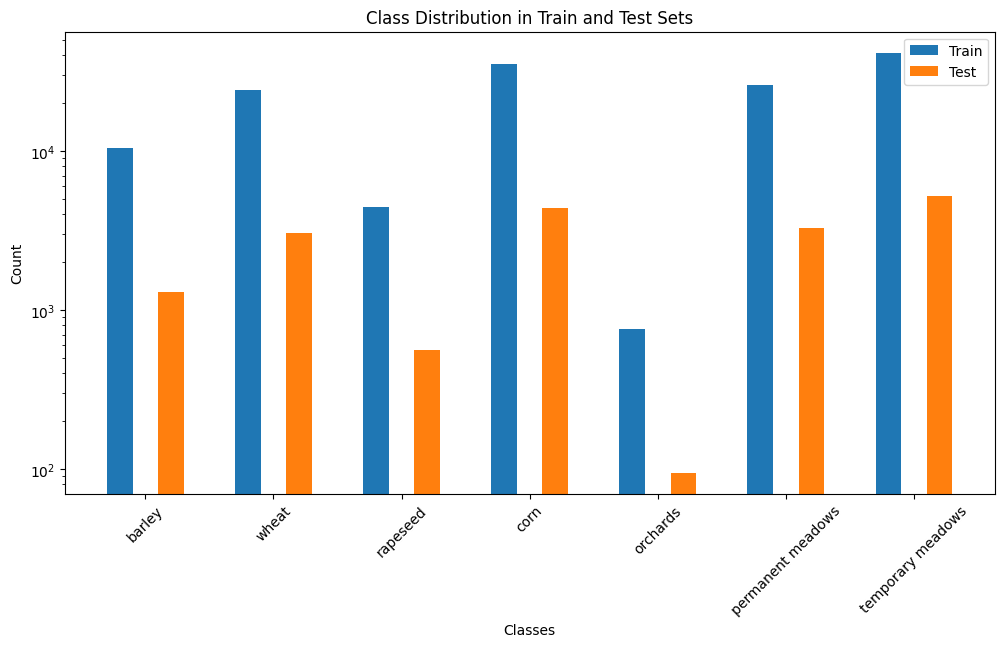

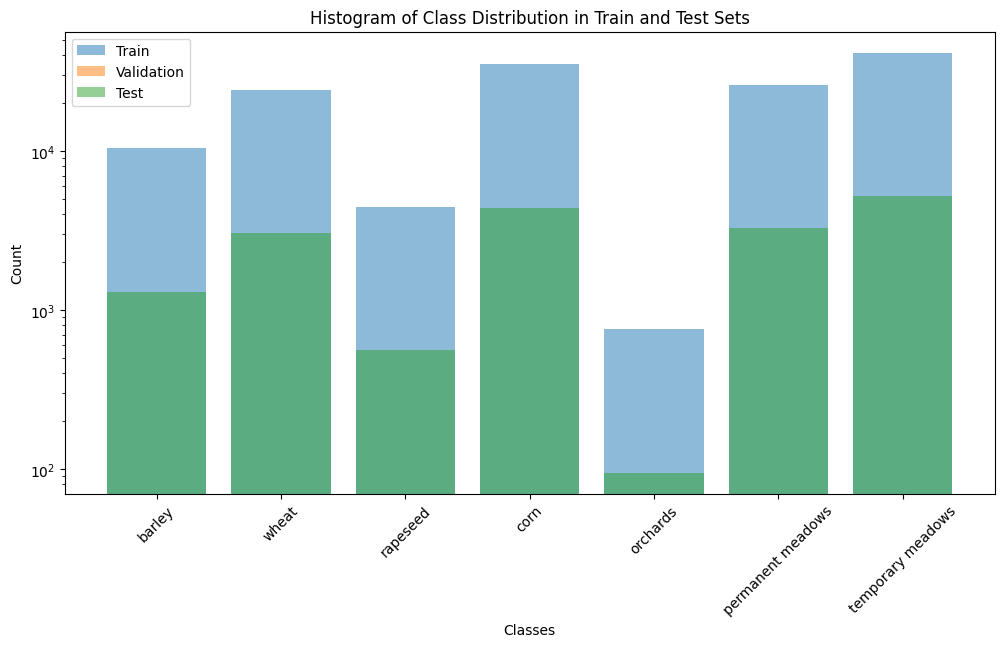


Class Distribution Table:
               Class    Train  Validation    Test
0             barley  10437.0         0.0  1304.0
1              wheat  24294.0         0.0  3037.0
2           rapeseed   4474.0         0.0   559.0
3               corn  35192.0         0.0  4399.0
4           orchards    755.0         0.0    95.0
5  permanent meadows  26120.0         0.0  3265.0
6  temporary meadows  41609.0         0.0  5201.0


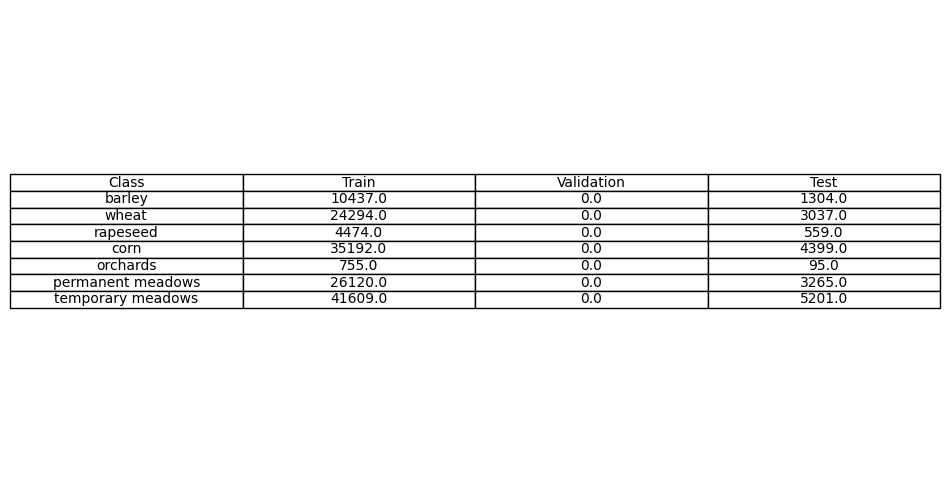

In [12]:
%matplotlib inline
# Initialize dataset
if combine:
    dataset1 = TS_COV(root_dir = root_dir, np_file = npz_file, estimator = 'scm', combo=combo, temp=temp)
    dataset2 = TS_COV(root_dir = root_dir, np_file = npz_file1, estimator = 'scm', combo=combo, temp=temp)
    dataset3 = TS_COV(root_dir = root_dir, np_file = npz_file2, estimator = 'scm', combo=combo, temp=temp)
    dataset4 = TS_COV(root_dir = root_dir, np_file = npz_file3, estimator = 'scm', combo=combo, temp=temp)
else:
    dataset = TS_COV(root_dir=root_dir, np_file=npz_file, estimator= 'scm', combo=combo, temp=temp)

# Split data into train, validation, and test sets
if combine:
    train_loader, test_loader, all_labels = create_dataloaders(test_index, dataset1, dataset2, dataset3, dataset4, batch_size=batch_size)
    # Calculate class weights
    concatenated_labels = np.concatenate(all_labels)
    weights = calculate_class_weights(concatenated_labels)   
    weights = weights.to(device)
    print(weights)
    # Plot class distribution
    val_loader = None
    plot_class_distribution(train_loader, val_loader, test_loader, n_classes=n_classes, combo=combo, folder_name=folder_name)
else:
    if val is not None:
        train_indices, test_indices = train_test_split(list(range(len(dataset))),
                                                        test_size=test_size, stratify=dataset.y, random_state=random_seed)
        test_indices, val_indices = train_test_split(test_indices,
                                                    test_size=val_size, stratify=dataset.y[test_indices], random_state=random_seed)
    else:
        train_indices, test_indices = train_test_split(list(range(len(dataset))),
                                                    test_size=test_size, stratify=dataset.y, random_state=random_seed)
        val_indices = None

    # Calculate class weights
    weights = calculate_class_weights(dataset.y)
    weights = weights.to(device)

    # Create data loaders
    if val:
        train_loader, val_loader, test_loader = create_data_loaders(dataset, train_indices, val_indices, test_indices, batch_size, val=val)
    else:
        train_loader, test_loader = create_data_loaders(dataset, train_indices, val_indices, test_indices, batch_size, val=val)
        val_loader = None

    # Plot class distribution
    plot_class_distribution(train_loader, val_loader, test_loader, n_classes=n_classes, combo=combo, folder_name=folder_name)

In [13]:
# access one matri
if combo:
    for x1,x2, y in train_loader:
        print(x1)
        print(x2.shape)
        print(y.shape)
        break
else:
    for x, y in train_loader:
        print(x.shape)
        print(y.shape)
        break
    

tensor([[[[0.1503, 0.2004, 0.2189,  ..., 0.1741, 0.1501, 0.1555],
          [0.2004, 0.2696, 0.2946,  ..., 0.2324, 0.1996, 0.2074],
          [0.2189, 0.2946, 0.3220,  ..., 0.2538, 0.2180, 0.2265],
          ...,
          [0.1741, 0.2324, 0.2538,  ..., 0.2019, 0.1742, 0.1804],
          [0.1501, 0.1996, 0.2180,  ..., 0.1742, 0.1516, 0.1563],
          [0.1555, 0.2074, 0.2265,  ..., 0.1804, 0.1563, 0.1619]]],


        [[[0.3335, 0.4285, 0.4379,  ..., 0.2616, 0.2728, 0.3013],
          [0.4285, 0.5527, 0.5653,  ..., 0.3360, 0.3487, 0.3856],
          [0.4379, 0.5653, 0.5783,  ..., 0.3433, 0.3557, 0.3936],
          ...,
          [0.2616, 0.3360, 0.3433,  ..., 0.2055, 0.2156, 0.2374],
          [0.2728, 0.3487, 0.3557,  ..., 0.2156, 0.2335, 0.2533],
          [0.3013, 0.3856, 0.3936,  ..., 0.2374, 0.2533, 0.2770]]],


        [[[0.3617, 0.3616, 0.3602,  ..., 0.2614, 0.2273, 0.1850],
          [0.3616, 0.3633, 0.3621,  ..., 0.2613, 0.2271, 0.1843],
          [0.3602, 0.3621, 0.3610,  ..

In [14]:
# initialize the model
model = initialize_model(combo, linear_classif, temp, device)
# model.load_state_dict(th.load('model_temp_linear_mm_209.ckpt'))
model.eval()

Combo model with Buseman classifier
Trainable total parameters: 85572


/opt/conda/lib/python3.10/site-packages/geoopt/manifolds/symmetric_positive_definite.py:52: UserWarning: SPDMetric.LEM is not fully implemented and results may be not as you expect
  warnings.warn(


LogEucRResNet_Combo(
  (model_temp): LogEucRResNet(
    (manifold_Stiefel): Stiefel(canonical) manifold
    (manifold_SPD): SymmetricPositiveDefinite(default_metric=SPDMetric.LEM) manifold
    (classiflayer): BusemanSimilarityClassifier(
      (manifold): Stiefel(canonical) manifold
      (linear): Linear(in_features=8, out_features=7, bias=True)
    )
    (fc_layer): Linear(in_features=3249, out_features=7, bias=True)
    (softmax): Softmax(dim=-1)
    (spectrum_map): Sequential(
      (0): Conv1d(1, 10, kernel_size=(5,), stride=(1,), padding=same)
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv1d(10, 5, kernel_size=(3,), stride=(1,), padding=same)
      (4): LeakyReLU(negative_slope=0.01)
      (5): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Conv1d(5, 1, kernel_size=(3,), stride=(1,), padding=same)
    )
  )
  (model_spectral): LogEucRRes

In [15]:
#setup loss and optimizer

if loss == "focal":
    loss_fn = FocalLoss(gamma=gamma_loss,weights=weights)
else:
    loss_fn = nn.CrossEntropyLoss(weights=weights)
#opti = MixOptimizer(model.parameters(),lr=lr)
opti = geoopt.optim.RiemannianAdam(model.parameters(), lr=lr)
if step_lr:
    scheduler = lr_scheduler.StepLR(opti, step_size, gamma_value)
else:
    scheduler = lr_scheduler.ExponentialLR(opti, gamma=gamma_value)


In [18]:
%matplotlib inline

if val:
    t1, t2, t3, t4, t5, best_epoch, best_model_path = train_model(model, train_loader, val_loader, loss_fn, opti, scheduler, epochs, folder_name, checkpoint_path, combo=combo)
else:
    t1, t2, t3, t4, t5, best_epoch, best_model_path = train_model(model, train_loader, test_loader, loss_fn, opti, scheduler, epochs, folder_name, checkpoint_path, combo=combo)


Epoch 1/200 - Train loss: 0.2525 - Val loss: 0.1475 - Train acc: 72.19% - Val acc: 79.14% - Test F1-score: 70.49
Elapsed time: 162.39 seconds
Best model checkpoint saved at bzh_combo_frh01/best_model.pth
Epoch 2/200 - Train loss: 0.1425 - Val loss: 0.1421 - Train acc: 79.40% - Val acc: 79.25% - Test F1-score: 71.69
Elapsed time: 163.06 seconds
Best model checkpoint saved at bzh_combo_frh01/best_model.pth
Epoch 3/200 - Train loss: 0.1319 - Val loss: 0.1337 - Train acc: 80.21% - Val acc: 80.24% - Test F1-score: 70.42
Elapsed time: 162.52 seconds
Best model checkpoint saved at bzh_combo_frh01/best_model.pth
Epoch 4/200 - Train loss: 0.1261 - Val loss: 0.1324 - Train acc: 80.71% - Val acc: 79.79% - Test F1-score: 72.54
Elapsed time: 162.88 seconds
Best model checkpoint saved at bzh_combo_frh01/best_model.pth
Epoch 5/200 - Train loss: 0.1219 - Val loss: 0.1369 - Train acc: 81.06% - Val acc: 81.19% - Test F1-score: 72.00
Elapsed time: 162.81 seconds
Epoch 6/200 - Train loss: 0.1181 - Val los

_LinAlgError: linalg.svd: (Batch element 0): The algorithm failed to converge because the input matrix contained non-finite values.

In [1]:

plot_training_results(t1, t2, t3, t4, t5,folder_name, plot_figure_name, best_epoch)

NameError: name 'plot_training_results' is not defined

In [19]:
best_model_path = "/kaggle/working/bzh_combo_frh01/best_model.pth"

/opt/conda/lib/python3.10/site-packages/geoopt/manifolds/symmetric_positive_definite.py:52: UserWarning: SPDMetric.LEM is not fully implemented and results may be not as you expect
  warnings.warn(


Combo model with Buseman classifier
Trainable total parameters: 85572
Model loaded from the best epoch 24
Model loaded
Validation loss: 0.1191
Validation accuracy: 82.05%
Model saved as bzh_combo_frh01.ckpt
                   precision    recall  f1-score   support

           barley       0.92      0.95      0.94      1304
            wheat       0.97      0.96      0.96      3037
         rapeseed       0.95      0.95      0.95       559
             corn       0.97      0.96      0.97      4399
         orchards       0.20      0.12      0.15        95
permanent meadows       0.60      0.58      0.59      3265
temporary meadows       0.72      0.74      0.73      5201

         accuracy                           0.82     17860
        macro avg       0.76      0.75      0.75     17860
     weighted avg       0.82      0.82      0.82     17860

Classification report saved as bzh_combo_frh01/bzh_combo_frh01_classification_report.txt


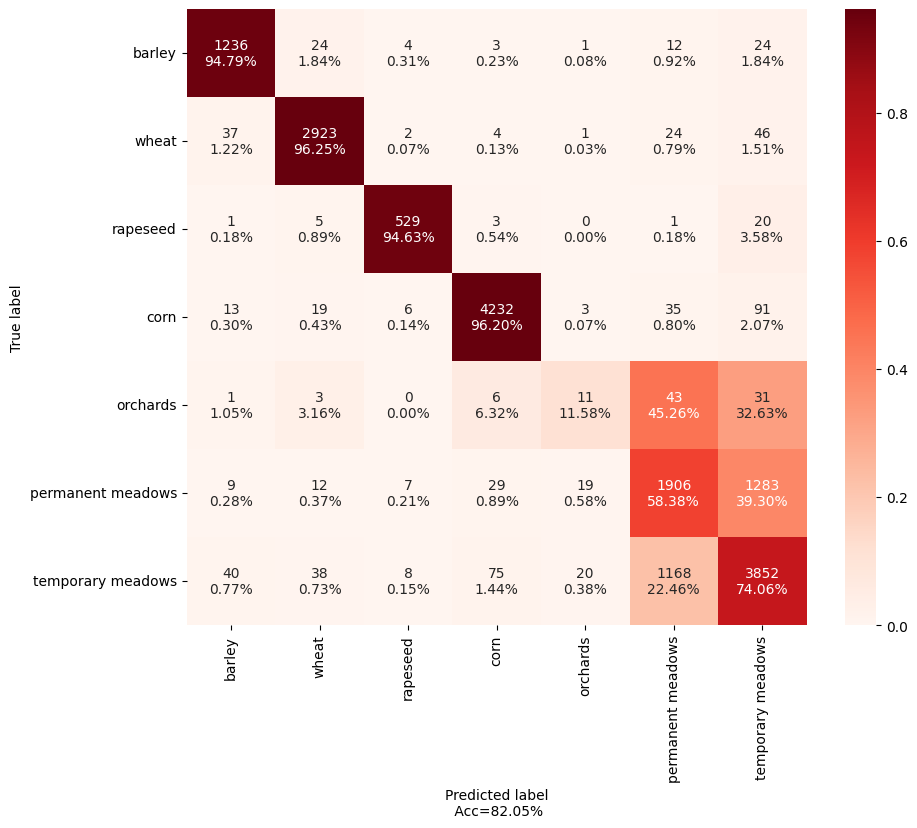

Figure saved as CM_bzh_combo_frh01.png


In [20]:
%matplotlib inline
acc_val = evaluate_model(best_model_path, test_loader, loss_fn, model_name, figure_name, folder_name, combo=combo, temp=temp, linear_classif=linear_classif, device=device)


In [ ]:
# path = r"C:\Users\Khizer Zakir\OneDrive - Université Bretagne Sud\thesis\Covariance_Thesis\notebooks\my_model\mm_21\model_combo_linear_mm_216.ckpt"
# # Load the best model
# ckpt = th.load(path)
# print(ckpt.keys())
# bimap = ckpt['model_temp.bimap1']
# array = bimap.squeeze().numpy()

# # Plot the array
# plt.figure(figsize=(6, 6))
# plt.imshow(array, cmap='viridis')  # Use a suitable colormap
# plt.colorbar()
# plt.title('Tensor Visualization')
# plt.show()


In [ ]:
# %matplotlib inline

# targets, outputs = gen_features(model,test_loader, combo =combo, linear_classif=linear_classif)
# tsne_plot(tsne_fig_name,targets, outputs)
